In [1]:
import numpy as np
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sys import path 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
current_path = os.getcwd()

systematics_path = os.path.join(current_path,'ingestion', 'systematics')
path.append(systematics_path)
from systematics import postprocess 
input_dir = os.path.join("D:", 'Uncertainty_Challenge_input_data')
train_data_file = os.path.join(input_dir, 'train', 'data', 'data.csv')
train_labels_file = os.path.join(input_dir, 'train', 'labels', "data.labels")
train_settings_file = os.path.join(input_dir, 'train', 'settings', "data.json")
train_weights_file = os.path.join(input_dir, 'train', 'weights', "data.weights")

# read train data
train_data = pd.read_csv(train_data_file)

# read train labels
with open(train_labels_file, "r") as f:
    train_labels = np.array(f.read().splitlines(), dtype=float)

# read train settings
with open(train_settings_file) as f:
    train_settings = json.load(f)

# read train weights
with open(train_weights_file) as f:
    train_weights = np.array(f.read().splitlines(), dtype=float
                       )
    


In [2]:
theta = 0.5
gamma_roi = train_weights[train_labels == 1].sum()
beta_roi = train_weights[train_labels == 0].sum()

def _sigma_asimov_CR(mu):
    return 0

def calculate_NLL( mu_scan, weight_data,use_CR=False):

    def _sigma_asimov_SR(mu):
        return mu*gamma_roi + beta_roi

    sum_data_total_SR = weight_data.sum()
    sum_data_total_CR = 0
    comb_llr = []
    for i, mu in enumerate(mu_scan):
        hist_llr = (
            -2
            * sum_data_total_SR
            * np.log((_sigma_asimov_SR(mu) / _sigma_asimov_SR(1.0)))
        ) + (2 * (_sigma_asimov_SR(mu) - _sigma_asimov_SR(1.0)))

        if use_CR:
            hist_llr_CR = (
                -2
                * sum_data_total_CR
                * np.log((_sigma_asimov_CR(mu) / _sigma_asimov_CR(1.0)))
                ) + (2 * (_sigma_asimov_CR(mu) - _sigma_asimov_CR(1.0)))
        else:
            hist_llr_CR=0
            #print("do not use CR")    
        #DR time is spent here ?        


        comb_llr.append(hist_llr + hist_llr_CR)

    comb_llr = np.array(comb_llr)
    comb_llr = comb_llr - np.amin(comb_llr)

    return comb_llr



In [3]:

    
train_data['label'] = train_labels
train_data['weight'] = train_weights
processed_data = postprocess(train_data)

labels = processed_data.pop('label')
weights = processed_data.pop('weight')

# split data into train and test
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(processed_data, labels, weights, test_size=0.2)

X_train ,X_holdout, y_train, y_holdout, w_train, w_holdout = train_test_split(X_train, y_train, w_train, test_size=0.5)

total_signal = np.sum(weights[labels == 1])
total_signal_train = np.sum(w_train[y_train == 1])
total_signal_test = np.sum(w_test[y_test == 1])
total_signal_holdout = np.sum(w_holdout[y_holdout == 1])
w_train[y_train == 1] *= total_signal / total_signal_train
w_test[y_test == 1] *= total_signal / total_signal_test
w_holdout[y_holdout == 1] *= total_signal / total_signal_holdout

total_background = np.sum(weights[labels == 0])
total_background_train = np.sum(w_train[y_train == 0])
total_background_test = np.sum(w_test[y_test == 0])
total_background_holdout = np.sum(w_holdout[y_holdout == 0])
w_train[y_train == 0] *= total_background / total_background_train
w_test[y_test == 0] *= total_background / total_background_test
w_holdout[y_holdout == 0] *= total_background / total_background_holdout



class_weights_train = (w_train[y_train == 0].sum(), w_train[y_train == 1].sum())

for i in range(len(class_weights_train)):  # loop on B then S target
    # training dataset: equalize number of background and signal
    w_train[y_train == i] *= max(class_weights_train) / class_weights_train[i]
    # test dataset : increase test weight to compensate for sampling

print("[*] --- Training Model")
X_train_sc = scaler.fit_transform(X_train)

from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, n_jobs=4)
model.fit(X_train_sc, y_train, sample_weight=w_train)

y_pred_train = model.predict_proba(X_train_sc)

from sklearn.metrics import roc_auc_score
print("[*] --- Training ROC AUC Score: ", roc_auc_score(y_train, y_pred_train[:, 1], sample_weight=w_train))



[*] --- Training Model
[*] --- Training ROC AUC Score:  0.9307928693159634


In [4]:
val_min = 1
theta_list = np.linspace(0.8, 1,100)
for theta in theta_list:

    print("theta: ", theta)

    # predict probabilities for holdout
    X_holdout_sc = scaler.transform(X_holdout)
    y_pred = model.predict_proba(X_holdout_sc)
    y_pred = y_pred[:,1]

    y_pred = (y_pred>theta).astype(int)
    gamma_roi = (w_holdout*(y_pred * y_holdout)).sum()
    beta_roi = (w_holdout*(y_pred * (1-y_holdout))).sum()


    X_test_sc = scaler.fit_transform(X_test)

    y_pred = model.predict_proba(X_test_sc) 

    y_pred = y_pred[:,1]
    y_pred = (y_pred>theta).astype(int)

    weight = w_test*(y_pred)

    mu_scan = np.linspace(0, 3, 100)
    hist_llr = calculate_NLL(mu_scan, weight, use_CR=False)
    hist_llr = np.array(hist_llr)

    val =  np.abs(mu_scan[np.argmin(hist_llr)] - 1)

    if val < val_min:
        val_min = val
        print("val: ", val)
        print("gamma_roi: ", gamma_roi)
        print("beta_roi: ", beta_roi)
        print("Uncertainity", np.sqrt(gamma_roi + beta_roi)/gamma_roi)
        Beta_roi = beta_roi
        Gamma_roi = gamma_roi

        best_theta = theta
        hist_llr_best = hist_llr


theta:  0.8
val:  0.09090909090909083
gamma_roi:  3208.0398435736556
beta_roi:  22987.946314876608
Uncertainity 0.05045191119235724
theta:  0.8020202020202021
theta:  0.8040404040404041
theta:  0.8060606060606061
theta:  0.8080808080808082
theta:  0.8101010101010101
theta:  0.8121212121212121
theta:  0.8141414141414142
theta:  0.8161616161616162
theta:  0.8181818181818182
theta:  0.8202020202020203
theta:  0.8222222222222223
theta:  0.8242424242424243
theta:  0.8262626262626263
theta:  0.8282828282828283
theta:  0.8303030303030303
theta:  0.8323232323232324
theta:  0.8343434343434344
theta:  0.8363636363636364
theta:  0.8383838383838385
theta:  0.8404040404040405
theta:  0.8424242424242424
theta:  0.8444444444444444
theta:  0.8464646464646465
theta:  0.8484848484848485
theta:  0.8505050505050505
theta:  0.8525252525252526
theta:  0.8545454545454546
theta:  0.8565656565656566
theta:  0.8585858585858586
theta:  0.8606060606060606
theta:  0.8626262626262626
theta:  0.8646464646464647
thet

C:\Users\ragan\AppData\Local\Temp\ipykernel_11276\1454219967.py:20: RuntimeWarning: invalid value encountered in scalar divide
  * np.log((_sigma_asimov_SR(mu) / _sigma_asimov_SR(1.0)))


In [5]:
print("best_theta: ", best_theta)
print("val_min: ", val_min)
print(Beta_roi)
print(Gamma_roi)
del beta_roi
del gamma_roi
beta_roi = Beta_roi
gamma_roi = Gamma_roi

best_theta:  0.8767676767676768
val_min:  0.0
12030.029702406091
2728.2684212242802


min NLL:  0.0
min NLL index:  33
min NLL mu:  1.0


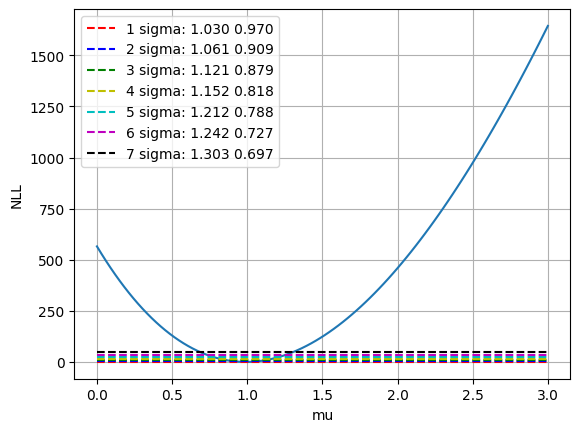

In [6]:




print("min NLL: ", min(hist_llr_best))
print("min NLL index: ", np.argmin(hist_llr_best))
print("min NLL mu: ", mu_scan[np.argmin(hist_llr_best)])


sigma_7 = (max(mu_scan[np.where((hist_llr_best <= 49) & (hist_llr_best >= 36))]), min(mu_scan[np.where((hist_llr_best < 49) & (hist_llr_best > 36))]))
sigma_6 = (max(mu_scan[np.where((hist_llr_best <= 36) & (hist_llr_best >= 25))]), min(mu_scan[np.where((hist_llr_best < 36) & (hist_llr_best > 25))]))
sigma_5 = (max(mu_scan[np.where((hist_llr_best <= 25) & (hist_llr_best >= 16))]), min(mu_scan[np.where((hist_llr_best < 25) & (hist_llr_best > 16))]))
sigma_4 = (max(mu_scan[np.where((hist_llr_best <= 16) & (hist_llr_best >= 9))]), min(mu_scan[np.where((hist_llr_best < 16) & (hist_llr_best > 9))]))
sigma_3 = (max(mu_scan[np.where((hist_llr_best <= 9) & (hist_llr_best >= 4))]), min(mu_scan[np.where((hist_llr_best < 9) & (hist_llr_best > 4))]))
sigma_2 = (max(mu_scan[np.where((hist_llr_best <= 4) & (hist_llr_best >= 1))]), min(mu_scan[np.where((hist_llr_best < 4) & (hist_llr_best > 1))]))
sigma_1 = (max(mu_scan[np.where((hist_llr_best <= 1) & (hist_llr_best >= 0))]), min(mu_scan[np.where((hist_llr_best < 1) & (hist_llr_best > 0))]))


plt.plot( mu_scan,hist_llr_best)
plt.hlines(1, 0, 3,  colors="r", linestyles="dashed", label=f"1 sigma: {sigma_1[0]:.3f} {sigma_1[1]:.3f}")
plt.hlines(4, 0, 3,  colors="b", linestyles="dashed", label=f"2 sigma: {sigma_2[0]:.3f} {sigma_2[1]:.3f}")
plt.hlines(9, 0, 3,  colors="g", linestyles="dashed", label=f"3 sigma: {sigma_3[0]:.3f} {sigma_3[1]:.3f}")
plt.hlines(16, 0, 3, colors="y", linestyles="dashed", label=f"4 sigma: {sigma_4[0]:.3f} {sigma_4[1]:.3f}")
plt.hlines(25, 0, 3, colors="c", linestyles="dashed", label=f"5 sigma: {sigma_5[0]:.3f} {sigma_5[1]:.3f}")
plt.hlines(36, 0, 3, colors="m", linestyles="dashed", label=f"6 sigma: {sigma_6[0]:.3f} {sigma_6[1]:.3f}")
plt.hlines(49, 0, 3, colors="k", linestyles="dashed", label=f"7 sigma: {sigma_7[0]:.3f} {sigma_7[1]:.3f}")
plt.legend()

plt.xlabel("mu")    
plt.ylabel("NLL")
plt.grid(True)
plt.show()



In [7]:
def shuffle_dataframe(df):
    # Convert DataFrame to NumPy array
    array = df.to_numpy()

    # Shuffle the array
    np.random.shuffle(array)

    # Convert the shuffled array back to a DataFrame
    shuffled_df = pd.DataFrame(array, columns=df.columns)

    return shuffled_df


signal_test:  5312.591511997331
background_test:  1546704.0102073848
signal_test_bs:  5312.591511997331
background_test_bs:  1546704.0102073848


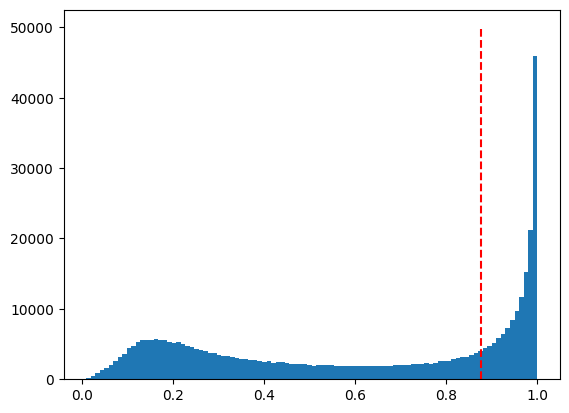

weight:  14730.660185516475
mu:  0.989869787774953
gamma_roi:  2728.2684212242802
beta_roi:  12030.029702406091
signal_test:  5312.591511997331
background_test:  1546704.0102073848
signal_test_bs:  5312.591511997331
background_test_bs:  1546704.0102073848


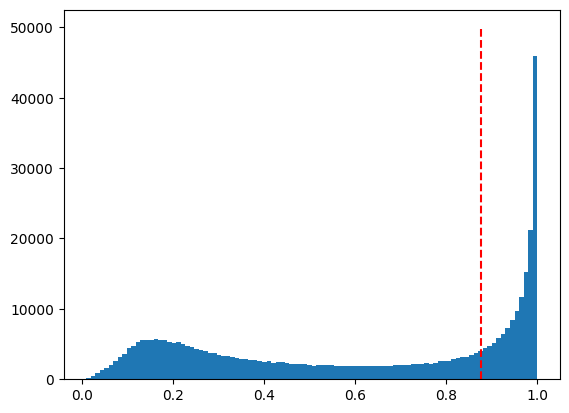

weight:  14730.660185516475
mu:  0.989869787774953
gamma_roi:  2728.2684212242802
beta_roi:  12030.029702406091


In [8]:
import bootstrap as bs
# from sklearn.utils import shuffle
for i in range(2):

    signal_test = w_test[y_test == 1]
    background_test = w_test[y_test == 0]

    print("signal_test: ", signal_test.sum())
    print("background_test: ", background_test.sum())


    test_bs = {'data':X_test, 'weights':w_test, 'label':y_test}

    test_df = test_bs['data']
    test_df['label'] = test_bs['label']    
    test_df['weights'] = test_bs['weights']

    shuffle_dataframe(test_df)

    y_test_bs = test_df.pop('label')
    w_test_bs = test_df.pop('weights')

    signal_test_bs = w_test_bs[y_test_bs == 1]
    background_test_bs = w_test_bs[y_test_bs == 0]
    print("signal_test_bs: ", signal_test_bs.sum())
    print("background_test_bs: ", background_test_bs.sum())



    X_test_bs = scaler.fit_transform(test_df)

    y_pred = model.predict_proba(X_test_bs)
    y_pred = y_pred[:,1]

    plt.hist(y_pred, bins=100)
    plt.vlines(best_theta, 0, 50000, colors="r", linestyles="dashed")
    plt.show()
    y_pred = (y_pred>best_theta).astype(int)


    weight = w_test_bs*(y_pred)

    print("weight: ", weight.sum())
    print("mu: ", (weight.sum() - beta_roi)/gamma_roi)
    print("gamma_roi: ", gamma_roi)
    print("beta_roi: ", beta_roi)

    mu_scan = np.linspace(0, 3, 100)
    hist_llr = calculate_NLL(mu_scan, weight, use_CR=False)
    hist_llr = np.array(hist_llr)

#     plt.plot( mu_scan,hist_llr)

# plt.hlines(1, 0, 3, colors="r", linestyles="dashed")
# plt.hlines(4, 0, 3, colors="b", linestyles="dashed")
# plt.hlines(9, 0, 3, colors="y", linestyles="dashed")


signal_test:  5312.591511997331
background_test:  1546704.0102073848
n:  4020
total_signal_weight:  5312.591511997331
total_background_weight:  1546704.0102073848
subset_signal_weight:  53.772448071005975
subset_background_weight:  15016.415789786823
signal_test_bs:  5220
background_test_bs:  1546265
weight:  9605
mu:  -0.8888530481608132
gamma_roi:  2728.2684212242802
beta_roi:  12030.029702406091
signal_test:  5312.591511997331
background_test:  1546704.0102073848
n:  4020
total_signal_weight:  5312.591511997331
total_background_weight:  1546704.0102073848
subset_signal_weight:  53.67131219291625
subset_background_weight:  15082.335086493524
signal_test_bs:  5339
background_test_bs:  1548274
weight:  17576
mu:  2.032780299199892
gamma_roi:  2728.2684212242802
beta_roi:  12030.029702406091
signal_test:  5312.591511997331
background_test:  1546704.0102073848
n:  4020
total_signal_weight:  5312.591511997331
total_background_weight:  1546704.0102073848
subset_signal_weight:  53.616374185

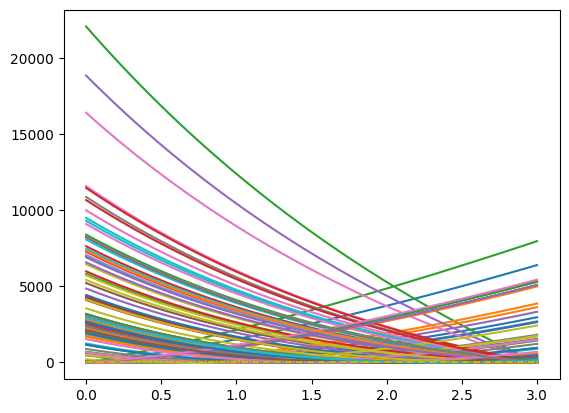

In [18]:
p16s = []
p84s = []
for i in range(100):

    signal_test = w_test[y_test == 1]
    background_test = w_test[y_test == 0]

    print("signal_test: ", signal_test.sum())
    print("background_test: ", background_test.sum())

    n = int(len(y_test)/100)
    print("n: ", n)
    test_bs = bs.bootstrap_data(X_test, w_test, y_test, n=n,seed=i)

    test_df = test_bs['data']
    test_df['label'] = test_bs['label']    
    test_df['weights'] = test_bs['weights']

    shuffle_dataframe(test_df)

    y_test_bs = test_df.pop('label')
    w_test_bs = test_df.pop('weights')

    signal_test_bs = w_test_bs[y_test_bs == 1]
    background_test_bs = w_test_bs[y_test_bs == 0]
    print("signal_test_bs: ", signal_test_bs.sum())
    print("background_test_bs: ", background_test_bs.sum())



    X_test_bs = scaler.fit_transform(test_df)

    y_pred = model.predict_proba(X_test_bs)
    y_pred = y_pred[:,1]

    y_pred = (y_pred>best_theta).astype(int)


    weight = w_test_bs*(y_pred)

    print("weight: ", weight.sum())
    print("mu: ", (weight.sum() - beta_roi)/gamma_roi)
    print("gamma_roi: ", gamma_roi)
    print("beta_roi: ", beta_roi)


    mu_scan = np.linspace(0, 3, 100)
    hist_llr = calculate_NLL(mu_scan, weight, use_CR=False)
    hist_llr = np.array(hist_llr)

    if (mu_scan[np.where((hist_llr <= 25) & (hist_llr >= 0.0))].size == 0):
        p16 = 0
        p84 = 0
    else:
        p16 = min(mu_scan[np.where((hist_llr <= 25) & (hist_llr >= 0.0))])
        p84 = max(mu_scan[np.where((hist_llr <= 25) & (hist_llr >= 0.0))]) 

    p16s.append(p16)
    p84s.append(p84)

    plt.plot( mu_scan,hist_llr)

plt.hlines(1, 0, 3, colors="r", linestyles="dashed")
plt.hlines(4, 0, 3, colors="b", linestyles="dashed")
plt.hlines(9, 0, 3, colors="y", linestyles="dashed")


p16s:  [0.0, 2.0, 1.4242424242424243, 3.0, 0.42424242424242425, 3.0, 3.0, 1.7575757575757576, 1.878787878787879, 1.4545454545454546, 0.33333333333333337, 1.7878787878787878, 3.0, 2.1515151515151514, 0.0, 0.0, 2.303030303030303, 1.9090909090909092, 3.0, 2.393939393939394, 0.4545454545454546, 0.06060606060606061, 3.0, 3.0, 0.18181818181818182, 2.4242424242424243, 2.393939393939394, 2.0, 2.3636363636363638, 3.0, 2.303030303030303, 1.7272727272727273, 0.0, 2.8181818181818183, 2.4242424242424243, 1.0303030303030303, 3.0, 0.8484848484848485, 3.0, 3.0, 2.2121212121212124, 0.0, 2.8181818181818183, 2.787878787878788, 3.0, 1.0303030303030303, 3.0, 3.0, 0.9393939393939394, 3.0, 1.4242424242424243, 0.0, 2.4242424242424243, 2.8484848484848486, 1.0303030303030303, 0.0, 3.0, 1.2121212121212122, 2.5757575757575757, 1.7878787878787878, 2.909090909090909, 1.7575757575757576, 1.0909090909090908, 3.0, 3.0, 3.0, 3.0, 2.0303030303030303, 0.9090909090909092, 3.0, 2.272727272727273, 2.0303030303030303, 1.9090

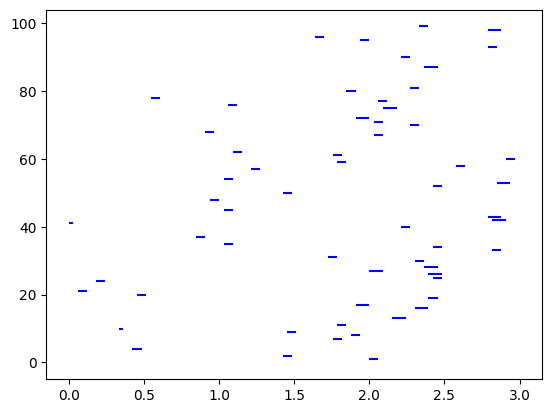

In [19]:
for i, (p16, p84) in enumerate(zip(p16s, p84s)):
    plt.hlines(y=i, xmin=p16, xmax=p84, colors='b')

print("p16s: ", p16s)
print("p84s: ", p84s)

In [11]:
1/0.02


50.0